## Importación de librerias

In [1]:
import torch
from transformers import AutoImageProcessor, AutoModel, Dinov2Model
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as T
import numpy as np
import pickle
from skimage.transform import resize
from tqdm import tqdm


from sklearn.model_selection import GridSearchCV, PredefinedSplit
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


## Load Data

In [2]:
train_dataset = pickle.load(open('../data/X_train_raw.pk', 'rb'))
val_dataset = pickle.load(open('../data/X_val_raw.pk', 'rb'))
test_dataset = pickle.load(open('../data/X_test_raw.pk', 'rb'))

In [3]:
X_train = train_dataset["image"]
y_train = train_dataset["Target"]

X_val = val_dataset["image"]
y_val = val_dataset["Target"]

X_test = test_dataset["image"]
y_test = test_dataset["Target"]

In [4]:
#Resize all images to 512,512
def resize_image_to512(dataset):
    dataset_fixed = []
    for x in dataset:
        if x.shape != (1,512,512):
            # quitar canal si lo tiene
            img = x[0] if x.ndim == 3 else x
            # redimensionar
            img_resized = resize(img, (512,512), preserve_range=True, anti_aliasing=True)
            # volver a poner canal
            img_resized = img_resized[np.newaxis, ...]
            dataset_fixed.append(img_resized.astype(np.float32))
        else:
            dataset_fixed.append(x.astype(np.float32))
    #To convert to array again
    dataset_fixed = np.concatenate(dataset_fixed)
    return dataset_fixed


In [5]:
#Resize X_train, X_val, X_test
X_train = resize_image_to512(X_train)
X_val = resize_image_to512(X_val)
X_test = resize_image_to512(X_test)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((13635, 512, 512), (3273, 512, 512), (2227, 512, 512))

In [7]:
pickle.dump([X_train, y_train, X_val, y_val, X_test, y_test], open('../data/dataset_512_train_val_test.pk', 'wb'))

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(open('../data/dataset_512_train_val_test.pk', 'rb'))

## Get Embeddings

In [3]:

# ===== Dataset para slices 2D =====
class Slices2D(data.Dataset):
    def __init__(self, images_2d, transform=None):
        """
        images_2d: lista/array de np.ndarray con shape (H, W), en escala de grises
        """
        self.images = images_2d
        self.t = transform

    def _to_pil_rgb(self, img2d):
        im = img2d.astype(np.float32)
        #Escala a [0,255] para poder convertir a imagen
        im = (im - im.min()) / (im.max() - im.min() + 1e-6)
        im = (im * 255.0).clip(0,255).astype(np.uint8)
        # Repite canal: gris -> RGB
        rgb = np.stack([im, im, im], axis=-1)
        return Image.fromarray(rgb)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self._to_pil_rgb(self.images[idx])
        if self.t:
            x = self.t(x)
        return x

# ===== Transforms para Dinov2 =====
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

# ===== DataLoader =====
def make_loader(images, batch_size=16):
    ds = Slices2D(images, transform=transform)
    return data.DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

# ===== Función para extraer embeddings =====
@torch.no_grad()
def extract_embeddings(images, model, batch_size=16, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    loader = make_loader(images, batch_size=batch_size)
    model = model.to(device).eval()

    embs_pool = []
    embs_cls = []
    embs_mean = []
    
    for xb in tqdm(loader, desc="Extrayendo embeddings"):
        xb = xb.to(device or "cpu", non_blocking=True)
        z = model(xb)             
        last_hidden = z.last_hidden_state
        cls_emb = last_hidden[:,0]
        emb_pool = z.pooler_output
        mean_emb = last_hidden[:, 1:, :].mean(1)
        embs_cls.append(cls_emb.cpu().numpy())
        embs_pool.append(emb_pool.cpu().numpy())
        embs_mean.append(mean_emb.detach().cpu().numpy())

    X = {
            "pool": np.concatenate(embs_pool, axis=0),
            "cls": np.concatenate(embs_cls, axis=0),
            "mean": np.concatenate(embs_mean, axis=0),
    }

    return X 


In [4]:
model_ID = 'facebook/dinov2-base'
model = Dinov2Model.from_pretrained(model_ID)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

cuda:0


In [6]:
X_train_emb = extract_embeddings(X_train, model, batch_size=32, device=str(device))                 # (n_train, C)
X_val_emb   = extract_embeddings(X_val,   model, batch_size=32, device=str(device))
X_test_emb  = extract_embeddings(X_test,  model, batch_size=32, device=str(device))

Extrayendo embeddings: 100%|█████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.39it/s]


In [7]:
pickle.dump([X_train_emb, X_val_emb, X_test_emb], open('../data/Embeddings_Dinov2_train_val_test.pk', 'wb'))

In [8]:
len(X_train_emb), len(X_val_emb), len(X_test_emb)

(3, 3, 3)

In [9]:
X_train_emb['pool'].shape, X_train_emb['cls'].shape, X_train_emb['mean'].shape

((13635, 768), (13635, 768), (13635, 768))

## Load Embeddings

In [4]:
embeddings = pickle.load(open('../data/Embeddings_Dinov2_train_val_test.pk', 'rb'))
X_train_emb, X_val_emb, X_test_emb = embeddings
X_train_emb = X_train_emb['pool']
X_val_emb = X_val_emb['pool']
X_test_emb = X_test_emb['pool']

In [5]:
X_train_emb.shape, X_val_emb.shape, X_test_emb.shape

((13635, 768), (3273, 768), (2227, 768))

## Training XGBoost Mlflow Dinov2 Embeddings


In [ ]:
# ---- Imports ----
import numpy as np
import pandas as pd
import pickle

import mlflow
import mlflow.sklearn
import mlflow.xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from mlflow.models.signature import infer_signature

# ---------- MLflow setup ----------
mlflow.set_experiment("cancer_cervical_Dino_emb_xgb")
mlflow.sklearn.autolog(log_models=False)   # dejamos el log manual del modelo al final

# ---------- Datos y split (train + val para GridSearchCV con PredefinedSplit) ----------
embeddings = pickle.load(open('../data/Embeddings_Dinov2_train_val_test.pk', 'rb'))
X_train_emb, X_val_emb, X_test_emb = embeddings
X_train_emb = X_train_emb['pool']
X_val_emb = X_val_emb['pool']
X_test_emb = X_test_emb['pool']

labels = pickle.load(open('../data/labels_train_val_test.pk', 'rb'))
y_train,y_val, y_test = labels



X = np.concatenate([X_train_emb, X_val_emb])
y = np.concatenate([y_train, y_val])

# Indica a GridSearch que use val como "test fold" durante CV
test_fold = np.concatenate([
    -1 * np.ones(len(X_train_emb), dtype=int),  # training samples
    np.zeros(len(X_val_emb), dtype=int)         # validation fold
])
cv = PredefinedSplit(test_fold)

# ---------- Balance de clases ----------
n_neg = np.sum(y_train == 0)
n_pos = np.sum(y_train == 1)
spw = float(n_neg) / float(n_pos)  # scale_pos_weight

# ---------- Hiperparámetros base ----------
n_estimators     = 100
subsample        = 0.7
reg_alpha        = 1.0
min_child_weight = 3.0
reg_lambda       = 0.0
gamma            = 7.0
learning_rate    = 0.3

# ---------- Estimador ----------
xgb = XGBClassifier(
    tree_method='hist',      # CPU
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=n_estimators,
    subsample=subsample,
    reg_alpha=reg_alpha,
    min_child_weight=min_child_weight,
    reg_lambda=reg_lambda,
    gamma=gamma,
    learning_rate=learning_rate,
    scale_pos_weight=spw
)

# ---------- Búsqueda de hiperparámetros ----------
xgb_param_grid = {
    'max_depth': [3, 6],   # se barrerá sobre este
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    cv=cv,               # usa el PredefinedSplit (train vs val)
    n_jobs=3,           
    verbose=2,
    scoring='f1_macro',
    refit=True
)

# ---------- Run de MLflow ----------
with mlflow.start_run(run_name="Dino_emb_xgb_cls"):
    # Entrenar búsqueda
    grid_search.fit(X, y)

    # ----- Log de parámetros (mejores + base) -----
    # mejores del grid
    mlflow.log_params({f"best__{k}": v for k, v in grid_search.best_params_.items()})
    # base (los que no barres en el grid)
    mlflow.log_params({
        "n_estimators": n_estimators,
        "subsample": subsample,
        "reg_alpha": reg_alpha,
        "min_child_weight": min_child_weight,
        "reg_lambda": reg_lambda,
        "gamma": gamma,
        "learning_rate": learning_rate,
        "scale_pos_weight": spw
    })

    # métrica de CV (promedio F1_macro)
    mlflow.log_metric("cv_best_f1_macro", grid_search.best_score_)

    # ----- Evaluación en TEST -----
    best_model = grid_search.best_estimator_

    # Asegura DataFrame para logging de signature/input_example
    def ensure_df(arr, base_name="f"):
        if isinstance(arr, pd.DataFrame):
            return arr
        cols = [f"{base_name}{i}" for i in range(arr.shape[1])]
        return pd.DataFrame(arr, columns=cols)

    X_test_df = ensure_df(X_test_emb, base_name="f")
    proba_test = best_model.predict_proba(X_test_df)[:, 1]
    preds_test_05 = (proba_test >= 0.5).astype(int)

    mlflow.log_metric("test_auc_roc", roc_auc_score(y_test, proba_test))
    mlflow.log_metric("test_f1_0.5", f1_score(y_test, preds_test_05, average="binary"))
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, preds_test_05))

    # ----- Registrar modelo SIN warning: input_example + signature -----
    input_example = X_test_df.iloc[:5].copy()
    proba_example = best_model.predict_proba(input_example)
    signature = infer_signature(input_example, proba_example)

    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path='Dino-xgb-model',
        input_example=input_example,
        signature=signature
    )


## XGBoost

In [6]:
X = np.concatenate([X_train_emb, X_val_emb])
y = np.concatenate([y_train, y_val])

X.shape, y.shape

((16908, 768), (16908,))

In [7]:
test_fold = np.concatenate([
    -1 * np.ones(len(X_train_emb), dtype=int),  # training samples
    np.zeros(len(X_val_emb), dtype=int)        # test samples
])

test_fold.shape

(16908,)

In [12]:
ps = PredefinedSplit(test_fold)

n_neg = np.sum(y_train == 0)
n_pos = np.sum(y_train == 1)
spw = n_neg / n_pos

xgb_gpu = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    device='cuda:1',
    eval_metric=['mlogloss'],
    min_child_weight=3,
    max_depth=6,
    reg_lambda=0,
    gamma=7,
    learning_rate=0.3,
    scale_pos_weight=spw,
    random_state=42,
    n_jobs=1
)

xgb_param_grid = {
    'n_estimators': [50, 100],
    'reg_alpha':  [0.1, 1.0, 10.0],
    'subsample': [0.7, 1.0],
}

grid_search = GridSearchCV(
        estimator=xgb_gpu,
        param_grid=xgb_param_grid,
        cv=ps,
        n_jobs=1,
        verbose=2,
        scoring='roc_auc')

grid_search.fit(X, y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ......n_estimators=50, reg_alpha=0.1, subsample=0.7; total time=   1.9s
[CV] END ......n_estimators=50, reg_alpha=0.1, subsample=1.0; total time=   1.8s
[CV] END ......n_estimators=50, reg_alpha=1.0, subsample=0.7; total time=   1.9s
[CV] END ......n_estimators=50, reg_alpha=1.0, subsample=1.0; total time=   1.8s
[CV] END .....n_estimators=50, reg_alpha=10.0, subsample=0.7; total time=   1.9s
[CV] END .....n_estimators=50, reg_alpha=10.0, subsample=1.0; total time=   1.8s
[CV] END .....n_estimators=100, reg_alpha=0.1, subsample=0.7; total time=   1.9s
[CV] END .....n_estimators=100, reg_alpha=0.1, subsample=1.0; total time=   1.9s
[CV] END .....n_estimators=100, reg_alpha=1.0, subsample=0.7; total time=   1.9s
[CV] END .....n_estimators=100, reg_alpha=1.0, subsample=1.0; total time=   1.9s
[CV] END ....n_estimators=100, reg_alpha=10.0, subsample=0.7; total time=   1.9s
[CV] END ....n_estimators=100, reg_alpha=10.0, s

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'n_estimators': [50, 100], 'reg_alpha': [0.1, 1.0, ...], 'subsample': [0.7, 1.0]}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,"PredefinedSpl...ape=(16908,)))"
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [13]:
# mejor hiperparametro y modelo para XGBoost

best_model_xb = grid_search.best_estimator_
best_param3_xb = grid_search.best_params_
best_param3_xb

{'n_estimators': 100, 'reg_alpha': 1.0, 'subsample': 0.7}

In [14]:
y_pred = best_model_xb.predict(X_test_emb)
xgb_report = classification_report(y_test, y_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1824
           1       0.26      0.19      0.22       403

    accuracy                           0.75      2227
   macro avg       0.54      0.54      0.54      2227
weighted avg       0.73      0.75      0.74      2227



In [15]:
y_proba = best_model_xb.predict_proba(X_test_emb)[:,1]
auc = roc_auc_score(y_test, y_proba)
print("AUC-ROC:", auc)

AUC-ROC: 0.6145697292238039


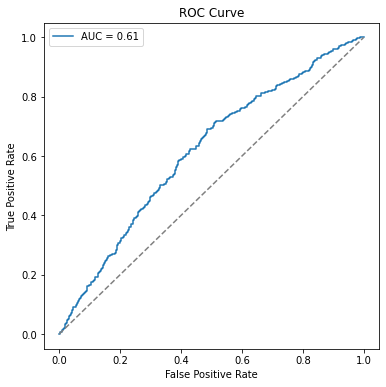

In [18]:
# Obtener puntos FPR (False Positive Rate), TPR (True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Logistic Regression

In [19]:
params = {"C": [0.01, 0.1],
          "penalty": ["l1", "l2"],
         }

log_reg_grid = GridSearchCV(LogisticRegression(solver='liblinear'),
                            params,
                            cv=ps,
                            scoring= "roc_auc",
                            n_jobs= -1,
                            verbose = 2                         
                           )
log_reg_grid.fit(X, y)

Fitting 1 folds for each of 4 candidates, totalling 4 fits


,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.01, 0.1], 'penalty': ['l1', 'l2']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,"PredefinedSpl...ape=(16908,)))"
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [21]:
best_model_lg = log_reg_grid.best_estimator_
best_params_lg= log_reg_grid.best_params_
best_params_lg

{'C': 0.1, 'penalty': 'l2'}

In [24]:
best_model_lg = log_reg_grid.best_estimator_
y_pred = best_model_lg.predict(X_test_emb)
lg_report = classification_report(y_test, y_pred)
print(lg_report)


              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1824
           1       0.25      0.24      0.25       403

    accuracy                           0.73      2227
   macro avg       0.54      0.54      0.54      2227
weighted avg       0.73      0.73      0.73      2227



In [25]:
y_proba = best_model_lg.predict_proba(X_test_emb)[:,1]
auc = roc_auc_score(y_test, y_proba)
print("AUC-ROC:", auc)

AUC-ROC: 0.592739214661965
[CV] END .................................C=0.01, penalty=l1; total time=   1.5s
[CV] END .................................C=0.01, penalty=l2; total time=   4.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   7.9s
[CV] END ..................................C=0.1, penalty=l1; total time=  13.0s


## PCA WITH Dinov2 Embeddings

In [29]:
from sklearn.decomposition import PCA
import numpy as np
# Definir PCA, por ejemplo para retener 95% de varianza
pca = PCA(n_components=0.95, random_state=42)

X_train_pca = pca.fit_transform(X)
# X_val_pca = pca.transform(X_val_emb)
X_test_pca = pca.transform(X_test_emb)

In [30]:
pickle.dump([X_train_pca, X_test_pca], open('../data/dataset_pca_train_test_dinov2.pk', 'wb'))

In [32]:
ps = PredefinedSplit(test_fold)

n_neg = np.sum(y_train == 0)
n_pos = np.sum(y_train == 1)
spw = n_neg / n_pos

xgb_gpu = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    device='cuda:1',
    eval_metric='aucpr',
    min_child_weight=3,
    max_depth=6,
    reg_lambda=0,
    gamma=7,
    learning_rate=0.3,
    scale_pos_weight=spw,
    random_state=42,
    n_jobs=1
)

xgb_param_grid = {
    'n_estimators': [50, 100],
    'reg_alpha':  [0.1, 1.0, 10.0],
    'subsample': [0.7, 1.0],
}

grid_search_pca = GridSearchCV(
        estimator=xgb_gpu,
        param_grid=xgb_param_grid,
        cv=ps,
        n_jobs=1,
        verbose=2,
        scoring='roc_auc')

grid_search_pca.fit(X_train_pca, y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ......n_estimators=50, reg_alpha=0.1, subsample=0.7; total time=   1.0s
[CV] END ......n_estimators=50, reg_alpha=0.1, subsample=1.0; total time=   0.9s
[CV] END ......n_estimators=50, reg_alpha=1.0, subsample=0.7; total time=   0.9s
[CV] END ......n_estimators=50, reg_alpha=1.0, subsample=1.0; total time=   0.9s
[CV] END .....n_estimators=50, reg_alpha=10.0, subsample=0.7; total time=   0.9s
[CV] END .....n_estimators=50, reg_alpha=10.0, subsample=1.0; total time=   0.9s
[CV] END .....n_estimators=100, reg_alpha=0.1, subsample=0.7; total time=   1.0s
[CV] END .....n_estimators=100, reg_alpha=0.1, subsample=1.0; total time=   0.9s
[CV] END .....n_estimators=100, reg_alpha=1.0, subsample=0.7; total time=   1.0s
[CV] END .....n_estimators=100, reg_alpha=1.0, subsample=1.0; total time=   0.9s
[CV] END ....n_estimators=100, reg_alpha=10.0, subsample=0.7; total time=   0.9s
[CV] END ....n_estimators=100, reg_alpha=10.0, s

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'n_estimators': [50, 100], 'reg_alpha': [0.1, 1.0, ...], 'subsample': [0.7, 1.0]}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,"PredefinedSpl...ape=(16908,)))"
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [33]:
# mejor hiperparametro y modelo para XGBoost

best_model_xb_pca = grid_search_pca.best_estimator_
best_param3_xb_pca = grid_search_pca.best_params_
best_param3_xb_pca

{'n_estimators': 50, 'reg_alpha': 10.0, 'subsample': 1.0}

In [35]:
y_pred = best_model_xb_pca.predict(X_test_pca)
xgb_report = classification_report(y_test, y_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1824
           1       0.26      0.23      0.24       403

    accuracy                           0.74      2227
   macro avg       0.54      0.54      0.54      2227
weighted avg       0.73      0.74      0.73      2227



In [36]:
y_proba = best_model_xb_pca.predict_proba(X_test_pca)[:,1]
auc = roc_auc_score(y_test, y_proba)
print("AUC-ROC:", auc)

AUC-ROC: 0.6011057420225503
